# First example modyfied

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import matplotlib.colors as colors
%matplotlib inline

In [10]:
from pyquil import Program, get_qc
from pyquil.gates import CZ, H, I, X, MEASURE
from pyquil.quilbase import Declare
from scipy.linalg import expm

In [11]:
from our_noise_new import add_decoherence_noise_to_I
from Calibration import Calibration

In [12]:
# We could ask for "2q-noisy-qvm" but we will be specifying
# our noise model as PRAGMAs on the Program itself.
qc = get_qc('2q-qvm')

In [13]:
%%time

# single step damping probability
damping_per_I = 0.02

# number of program executions
trials = 200

# I added:
cal = Calibration(2)

results_damping = []
lengths = np.arange(0, 201, 10, dtype=int)
for jj, num_I in enumerate(lengths):
    print("\r{}/{}, ".format(jj, len(lengths)), end="")


    p = Program(
        Declare("ro", "BIT", 1),
        X(0),
    )
    # p = qc.compile(p)
    # want increasing number of I-gates
    p.inst([I(0) for _ in range(num_I)])
    p.inst(MEASURE(0, ("ro", 0)))
    p = add_decoherence_noise_to_I(p, T1=cal.T1, T2=cal.T2)

    # overload identity I on qc 0
    # p.define_noisy_gate("I", [0], append_damping_to_gate(np.eye(2), damping_per_I))
    # I changed to:
    # p_comp = qc.compile(p)
    # p_comp = add_decoherence_noise(p_comp, T1=cal.T1, T2=cal.T2)
    
    p.wrap_in_numshots_loop(trials)
    qc.qam.random_seed = int(num_I)
    res = qc.run(p).readout_data.get("ro")
    results_damping.append([np.mean(res), np.std(res) / np.sqrt(trials)])

results_damping = np.array(results_damping)

20/21, CPU times: total: 547 ms
Wall time: 8.46 s


In [14]:
dense_lengths = np.arange(0, lengths.max()+1, .2)
survival_probs = (1-damping_per_I)**dense_lengths
logpmf = binom.logpmf(np.arange(trials+1)[np.newaxis, :], trials, survival_probs[:, np.newaxis])/np.log(10)

In [15]:
DARK_TEAL = '#48737F'
FUSCHIA = "#D6619E"
BEIGE = '#EAE8C6'
cm = colors.LinearSegmentedColormap.from_list('anglemap', ["white", FUSCHIA, BEIGE], N=256, gamma=1.5)

(0.0, 1.0)

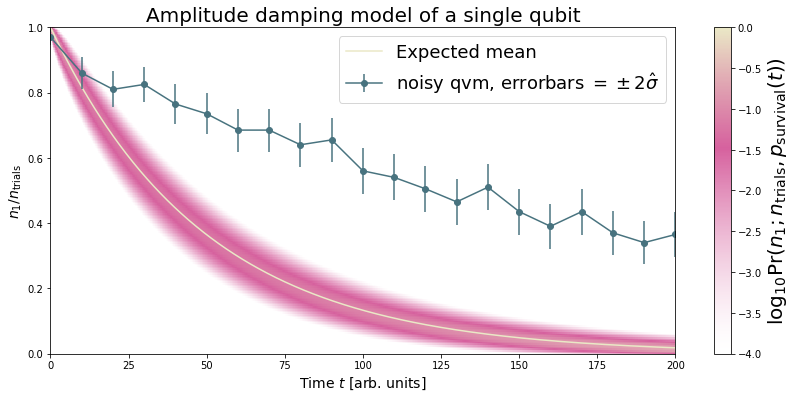

In [16]:
plt.figure(figsize=(14, 6))
plt.pcolor(dense_lengths, np.arange(trials+1)/trials, logpmf.T, cmap=cm, vmin=-4, vmax=logpmf.max())
plt.plot(dense_lengths, survival_probs, c=BEIGE, label="Expected mean")
plt.errorbar(lengths, results_damping[:,0], yerr=2*results_damping[:,1], c=DARK_TEAL,
             label=r"noisy qvm, errorbars $ = \pm 2\hat{\sigma}$", marker="o")
cb = plt.colorbar()
cb.set_label(r"$\log_{10} \mathrm{Pr}(n_1; n_{\rm trials}, p_{\rm survival}(t))$", size=20)

plt.title("Amplitude damping model of a single qubit", size=20)
plt.xlabel(r"Time $t$ [arb. units]", size=14)
plt.ylabel(r"$n_1/n_{\rm trials}$", size=14)
plt.legend(loc="best", fontsize=18)
plt.xlim(*lengths[[0, -1]])
plt.ylim(0, 1)

# First example modyfied

In [17]:
# I added
from Calibration import Calibration

In [18]:
from pyquil.quil import Program
from pyquil.paulis import PauliSum, PauliTerm, exponentiate, exponential_map, trotterize
from pyquil.gates import MEASURE, H, Z, RX, RZ, CZ
from pyquil.quilbase import Declare
import numpy as np

In [19]:
from numpy import pi
theta = pi/3
xy = PauliTerm('X', 0) * PauliTerm('Y', 1)
prog = exponential_map(xy)(theta)
print(prog)

H 0
RX(pi/2) 1
CNOT 0 1
RZ(2*pi/3) 1
CNOT 0 1
H 0
RX(-pi/2) 1



In [20]:
def get_compiled_prog(theta):
    return Program([
        RZ(-pi/2, 0),
        RX(-pi/2, 0),
        RZ(-pi/2, 1),
        RX( pi/2, 1),
        CZ(1, 0),
        RZ(-pi/2, 1),
        RX(-pi/2, 1),
        RZ(theta, 1),
        RX( pi/2, 1),
        CZ(1, 0),
        RX( pi/2, 0),
        RZ( pi/2, 0),
        RZ(-pi/2, 1),
        RX( pi/2, 1),
        RZ(-pi/2, 1),
    ])

In [21]:
from pyquil import get_qc
qc = get_qc("2q-qvm")

In [22]:
thetas = np.linspace(-pi, pi, num=20)

In [24]:
from our_noise_new import add_noise_to_program
trials = 500
records = []
# I added
cal = Calibration(2)

for theta in thetas:

    prog = get_compiled_prog(theta)
    # I added T2=(t1/2)
    noisy = add_noise_to_program(qc, prog, cal, False)
    noisy.inst([
        Declare("ro", "BIT", 2),
        MEASURE(0, ("ro", 0)),
        MEASURE(1, ("ro", 1)),
    ])
    noisy.wrap_in_numshots_loop(trials)
    bitstrings = qc.run(noisy).readout_data.get("ro")

    # Expectation of Z0 and Z1
    z0, z1 = 1 - 2*np.mean(bitstrings, axis=0)

    # Expectation of ZZ by computing the parity of each pair
    zz = 1 - (np.sum(bitstrings, axis=1) % 2).mean() * 2

    record = {
        'z0': z0,
        'z1': z1,
        'zz': zz,
        'theta': theta,
        # 't1': t1,
    }
    records += [record]

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

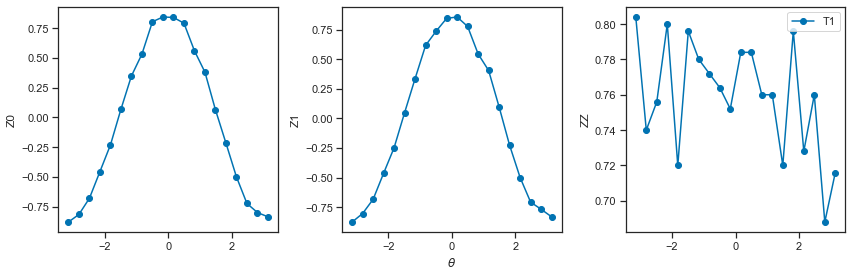

In [26]:
# import pandas as pd
# df_all = pd.DataFrame(records)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

# I added:
thetas2 = [record['theta'] for record in records]
z0s = [record['z0'] for record in records]
z1s = [record['z1'] for record in records]
zzs = [record['zz'] for record in records]
ax1.plot(thetas2, z0s, 'o-')
ax2.plot(thetas2, z1s, 'o-')
ax3.plot(thetas2, zzs, 'o-', label='T1')

# for t1 in t1s:
#     df = df_all.query('t1 == @t1')

#     ax1.plot(df['theta'], df['z0'], 'o-')
#     ax2.plot(df['theta'], df['z1'], 'o-')
#     ax3.plot(df['theta'], df['zz'], 'o-', label='T1 = {:.0f} us'.format(t1*1e6))

ax3.legend(loc='best')

ax1.set_ylabel('Z0')
ax2.set_ylabel('Z1')
ax3.set_ylabel('ZZ')
ax2.set_xlabel(r'$\theta$')
fig.tight_layout()

In [27]:
from pyquil.quilbase import Gate
for i in noisy:
    if isinstance(i, Gate):
        print(i.name)


RZ
RX
RZ
RX
CZ
NOISY-I
NOISY-I
RZ
RX
RZ
RX
CZ
NOISY-I
NOISY-I
RX
RZ
RZ
RX
RZ


In [ ]:
prog = Program()
prog += RZ